In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [41]:
df_ecommerce= pd.read_json('1_ecommerce.jsonl', lines=True)
df_ecommerce.head(5)

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."


In [42]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671803 entries, 0 to 1671802
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   session  1671803 non-null  int64 
 1   events   1671803 non-null  object
dtypes: int64(1), object(1)
memory usage: 25.5+ MB


In [43]:
# for each session, we will create a list of items that the user has clicked on, removing duplicates
clicks_items_list = []
carts_items_list = []
orders_items_list = []

for events in df_ecommerce.events:
    clicks = []
    carts = []
    orders = []
    for e in events:
        if e['type'] == 'clicks':
            clicks.append(e['aid'])
        if e['type'] == 'carts':
            carts.append(e['aid'])
        if e['type'] == 'orders':
            orders.append(e['aid'])

    clicks_items_list.append(list(clicks))
    carts_items_list.append(list(carts))
    orders_items_list.append(list(orders))

In [44]:
df_ecommerce['clicks'] = clicks_items_list
df_ecommerce['carts'] = carts_items_list
df_ecommerce['orders'] = orders_items_list
df = df_ecommerce.drop(columns=["events"], axis=1)

In [45]:
df.head()

,session,clicks,carts,orders
0,12899779,[59625],[],[]
1,12899780,"[1142000, 582732, 973453, 736515, 1142000]",[],[]
2,12899781,"[141736, 199008, 57315, 194067, 199008, 199008...",[199008],[]
3,12899782,"[1669402, 1494780, 1494780, 1494780, 1674681, ...","[1494780, 413962, 779477, 562753, 476063, 7794...","[1669402, 829180, 1696036, 479970, 834354, 103..."
4,12899783,"[255297, 1114789, 255297, 300127, 198385, 3001...",[],[]


In [46]:
# Calculate the length of the lists for each category (assuming df_ecommerce is already defined)
clicks_length = df_ecommerce['clicks'].apply(len)
carts_length = df_ecommerce['carts'].apply(len)
orders_length = df_ecommerce['orders'].apply(len)

In [47]:
# Function to add counts above the bars (with adjusted spacing)
def add_counts(ax, data, color, bins):
    counts, bins_edges, patches = ax.hist(data, bins=bins, edgecolor='black', alpha=0.7, color=color, range=(0, bins))
    ax.set_xticks(bins_edges)
    for count, patch in zip(counts, patches):
        height = patch.get_height()
        # Aggiungi il numero sopra ogni barra con un po' di margine
        ax.text(patch.get_x() + patch.get_width() / 2, height + 1, f'{int(count)}',
                ha='left', va='bottom', fontsize=8, rotation=20)

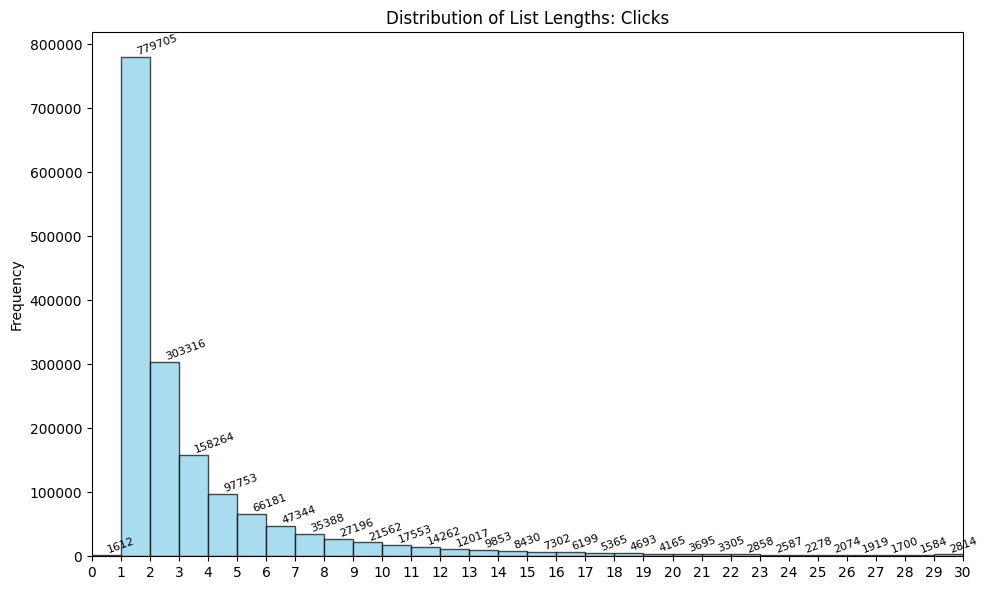

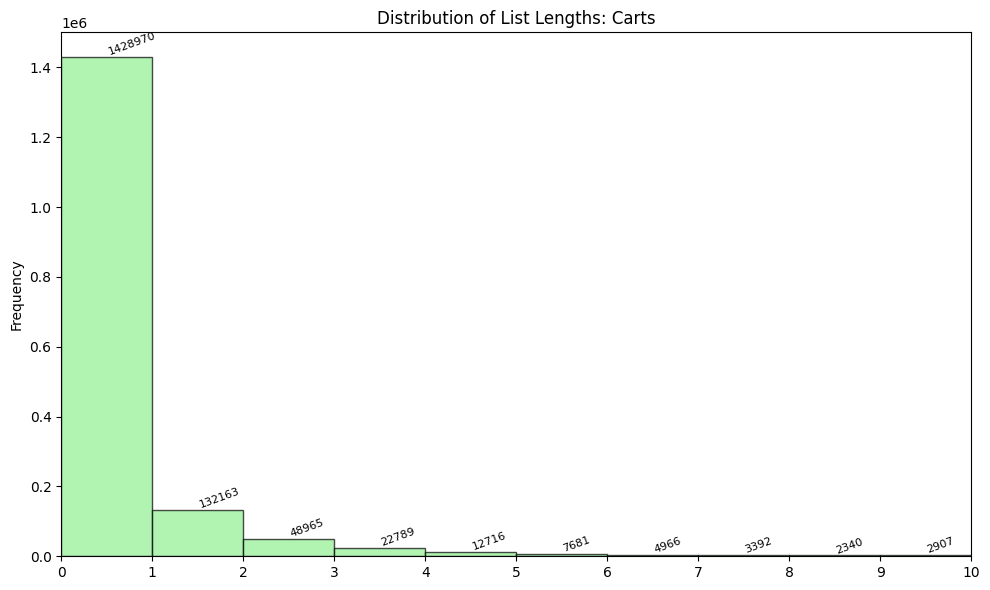

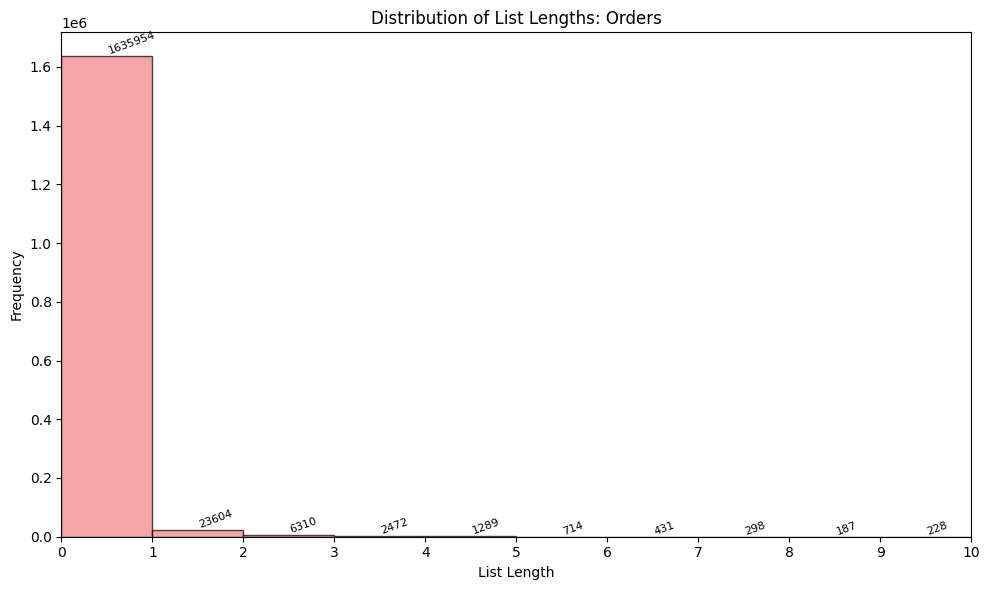

In [48]:
plt.figure(figsize=(10, 6))
ax1 = plt.gca()  # Get the current axis
add_counts(ax1, clicks_length, color='skyblue', bins=30)
ax1.set_title('Distribution of List Lengths: Clicks')
ax1.set_ylabel('Frequency', fontsize=10)
ax1.set_xlim(0, 30)  # Limit the x-axis from 0 to 30
plt.tight_layout()  # Optimize the layout
plt.show()

# Plot for Carts
plt.figure(figsize=(10, 6))
ax2 = plt.gca()  # Get the current axis
add_counts(ax2, carts_length, color='lightgreen', bins=10)
ax2.set_title('Distribution of List Lengths: Carts')
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_xlim(0, 10)  # Limit the x-axis from 0 to 10
plt.tight_layout()  # Optimize the layout
plt.show()

# Plot for Orders
plt.figure(figsize=(10, 6))
ax3 = plt.gca()  # Get the current axis
add_counts(ax3, orders_length, color='lightcoral', bins=10)
ax3.set_title('Distribution of List Lengths: Orders')
ax3.set_xlabel('List Length', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_xlim(0, 10)  # Limit the x-axis from 0 to 10
plt.tight_layout()  # Optimize the layout
plt.show()

In [49]:
# takes only the session with items length higher than 20
df_truncated = df[df['clicks'].apply(lambda x: len(x) > 10)]
df = df_truncated.copy()
# redefine index
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115929 entries, 0 to 115928
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   session  115929 non-null  int64 
 1   clicks   115929 non-null  object
 2   carts    115929 non-null  object
 3   orders   115929 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.5+ MB


In [50]:
# Explode each column (clicks, carts, orders)
df_clicks = df[['session', 'clicks']].explode('clicks').rename(columns={'clicks': 'item'}).dropna(subset=['item'])
df_carts = df[['session', 'carts']].explode('carts').rename(columns={'carts': 'item'}).dropna(subset=['item'])
df_orders = df[['session', 'orders']].explode('orders').rename(columns={'orders': 'item'}).dropna(subset=['item'])

# Concatenate the exploded dataframes
df_concat = pd.concat([df_clicks, df_carts, df_orders])

# Create a new column for each category indicating whether the item is present in that category
df_concat['click'] = df_concat['item'].isin(df_clicks['item']).astype(int)
df_concat['cart'] = df_concat['item'].isin(df_carts['item']).astype(int)
df_concat['order'] = df_concat['item'].isin(df_orders['item']).astype(int)

# Drop duplicates based on session and item
df_concat = df_concat.drop_duplicates(subset=['session', 'item'])

# Reset index after dropping duplicates
df_concat

,session,item,click,cart,order
0,12899782,1669402,1,1,1
0,12899782,1494780,1,1,0
0,12899782,1674681,1,1,0
0,12899782,602722,1,1,0
0,12899782,1596098,1,1,1
...,...,...,...,...,...
115356,14557158,1419870,1,1,1
115600,14562469,326854,1,0,1
115796,14567152,459953,1,1,1
115796,14567152,1038897,1,1,1


In [51]:
print(f"The user-item after filtering should be {df_concat.session.nunique()} x {df_concat.item.nunique()}")

The user-item after filtering should be 115929 x 501272


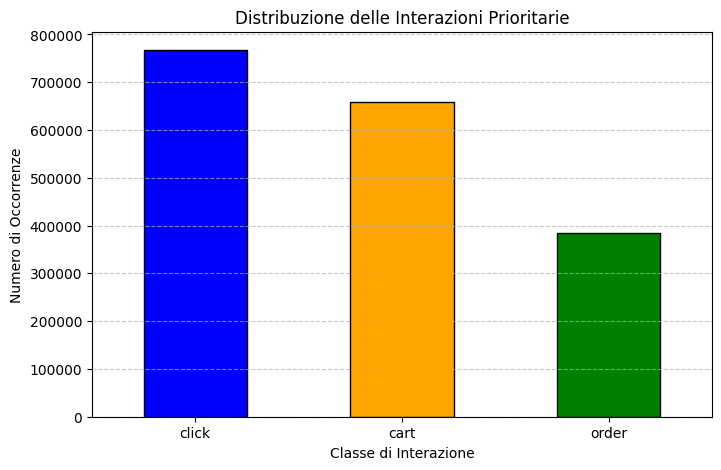

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Supponiamo che il tuo DataFrame sia 'df' con colonne ['session', 'item', 'click', 'cart', 'order']

# Crea una colonna 'class' con priorità: Order > Cart > Click
df_concat['class'] = 'click'  # Default se nessun'altra azione è presente
df_concat.loc[df_concat['cart'] > 0, 'class'] = 'cart'  # Se ha almeno un cart, diventa 'cart'
df_concat.loc[df_concat['order'] > 0, 'class'] = 'order'  # Se ha almeno un order, diventa 'order'

# Conta le occorrenze delle classi risultanti
class_counts = df_concat['class'].value_counts()

# Plot della distribuzione delle classi
plt.figure(figsize=(8, 5))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green'], edgecolor='black')

# Etichette e titolo
plt.xlabel("Classe di Interazione")
plt.ylabel("Numero di Occorrenze")
plt.title("Distribuzione delle Interazioni Prioritarie")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.show()

In [52]:
def sgd_matrix_factorization(df, k=10, alpha=0.01, lambda_reg=0.1, num_epochs=20, w_click=1, w_cart=3, w_order=5, test_size=0.2, validation_size=0.1):
    """
    Stochastic Gradient Descent (SGD) for Unconstrained Matrix Factorization with user and item biases.

    Parameters:
    df : pandas.DataFrame
        Filtered dataset containing columns: 'session', 'item', 'click', 'cart', 'order'.
    k : int
        Number of latent factors.
    alpha : float
        Learning rate.
    lambda_reg : float
        Regularization parameter.
    num_epochs : int
        Number of training epochs.
    w_click, w_cart, w_order : int
        Weights for click, cart, and order actions.
    test_size : float
        Fraction of the data to be used for testing.
    validation_size : float
        Fraction of the data to be used for validation.

    Returns:
    U : np.ndarray
        User latent factor matrix.
    V : np.ndarray
        Item latent factor matrix.
    b_u : np.ndarray
        User bias vector.
    b_i : np.ndarray
        Item bias vector.
    b : float
        Global bias.
    losses : list
        List of training loss values per epoch.
    val_losses : list
        List of validation loss values per epoch.
    test_loss : float
        Final loss on the test set.
    """
    # Map session (users) and items to consecutive indices
    users = {u: i for i, u in enumerate(df['session'].unique())}
    items = {i: j for j, i in enumerate(df['item'].unique())}

    num_users = len(users)
    num_items = len(items)

    # Initialize U, V, and biases
    U = np.random.rand(num_users, k)
    V = np.random.rand(num_items, k)
    b_u = np.zeros(num_users)
    b_i = np.zeros(num_items)
    b = 0  # Global bias

    # Create (u, i, r_ui) tuples for all interactions
    data = []

    # iter throw all the rows of the dataframe
    # and create a list of tuples (user, item, rating)
    # Assign ratings to interactions
    for _, row in df.iterrows():
        u = users[row['session']]
        i = items[row['item']]

        # if this user has perform an action on this item, we assign a rating based on the action 
        # type starting from the most important one 
        # (order > cart > click)
        if row['order'] > 0:
            r_ui = w_order
        elif row['cart'] > 0:
            r_ui = w_cart
        elif row['click'] > 0:
            r_ui = w_click
        else:
            continue  # Skip interactions with no recorded action

        data.append((u, i, r_ui))

    # Split the data into training, validation, and test sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=validation_size, random_state=42)

    # # Compute global bias as the mean rating of the training set
    # if train_data:
    #     b = np.mean([r for _, _, r in train_data])
    #
    # print("Datasets created! Starting training...")
    #
    # # Training using SGD
    # losses = []
    # val_losses = []
    #
    # for epoch in range(num_epochs):
    #     np.random.shuffle(train_data)  # Shuffle data to improve convergence
    #     total_loss = 0
    #     total_val_loss = 0
    #
    #     U_temp = U.copy()
    #     V_temp = V.copy()
    #
    #     # Training phase
    #     for u, i, r_ui in train_data:
    #         # Predict the rating using the current model parameters
    #         # b is the global bias, b_u[u] is the user bias, b_i[i] is the item bias
    #         pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
    #
    #         # Calculate the error
    #         e_ui = r_ui - pred  # Error
    #
    #         # Update biases
    #         # alpha is the learning rate, lambda_reg is the regularization parameter
    #         b_u[u] += alpha * (e_ui - lambda_reg * b_u[u])
    #         b_i[i] += alpha * (e_ui - lambda_reg * b_i[i])
    #
    #         # Update latent factors using temporary matrices
    #         U_temp[u, :] += alpha * (e_ui * V[i, :] - lambda_reg * U[u, :])
    #         V_temp[i, :] += alpha * (e_ui * U[u, :] - lambda_reg * V[i, :])
    #
    #         total_loss += e_ui ** 2  # Sum of squared errors
    #     total_loss /= len(train_data)
    #     total_loss = np.sqrt(total_loss)
    #
    #     # Copy back updated matrices
    #     U = U_temp
    #     V = V_temp
    #
    #     # Validation phase (calculate validation loss)
    #     for u, i, r_ui in val_data:
    #         pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
    #         e_ui = r_ui - pred  # Error
    #         total_val_loss += e_ui ** 2
    #     total_val_loss /= len(val_data)
    #     total_val_loss = np.sqrt(total_val_loss)
    #
    #     # Append losses for the current epoch
    #     losses.append(total_loss)
    #     val_losses.append(total_val_loss)
    #
    #     print(f"Epoch {epoch+1}/{num_epochs}, RMSE Train Loss: {total_loss:.4f}, RMSE Val Loss: {total_val_loss:.4f}")
    #
    # # Test phase (calculate test loss)
    # test_loss = 0
    # for u, i, r_ui in test_data:
    #     pred = b + b_u[u] + b_i[i] + np.dot(U[u, :], V[i, :])
    #     e_ui = r_ui - pred  # Error
    #     test_loss += e_ui ** 2
    # test_loss /= len(test_data)
    # test_loss = np.sqrt(test_loss)
    #
    # print(f"Final Test RMSE: {test_loss:.4f}")
    #
    # return U, V, b_u, b_i, b, losses, val_losses, test_loss

In [53]:
U, V, b_u, b_i, b, losses, val_losses, test_loss = sgd_matrix_factorization(df_concat, k=20, alpha=0.001, num_epochs=20, w_click=1, w_order=5, w_cart=10)

Datasets created! Starting training...
Epoch 1/20, RMSE Train Loss: 6.3969, RMSE Val Loss: 5.7613
Epoch 2/20, RMSE Train Loss: 5.6161, RMSE Val Loss: 5.4445
Epoch 3/20, RMSE Train Loss: 5.2053, RMSE Val Loss: 5.4485
Epoch 4/20, RMSE Train Loss: 4.9936, RMSE Val Loss: 5.5637
Epoch 5/20, RMSE Train Loss: 4.7030, RMSE Val Loss: 4.7239
Epoch 6/20, RMSE Train Loss: 4.3769, RMSE Val Loss: 4.5633
Epoch 7/20, RMSE Train Loss: 4.1905, RMSE Val Loss: 4.4386
Epoch 8/20, RMSE Train Loss: 4.0381, RMSE Val Loss: 4.3321
Epoch 9/20, RMSE Train Loss: 3.9056, RMSE Val Loss: 4.2397
Epoch 10/20, RMSE Train Loss: 3.7888, RMSE Val Loss: 4.1586
Epoch 11/20, RMSE Train Loss: 3.6845, RMSE Val Loss: 4.0868
Epoch 12/20, RMSE Train Loss: 3.5906, RMSE Val Loss: 4.0227
Epoch 13/20, RMSE Train Loss: 3.5053, RMSE Val Loss: 3.9651
Epoch 14/20, RMSE Train Loss: 3.4274, RMSE Val Loss: 3.9129
Epoch 15/20, RMSE Train Loss: 3.3557, RMSE Val Loss: 3.8654
Epoch 16/20, RMSE Train Loss: 3.2894, RMSE Val Loss: 3.8219
Epoch 17/2

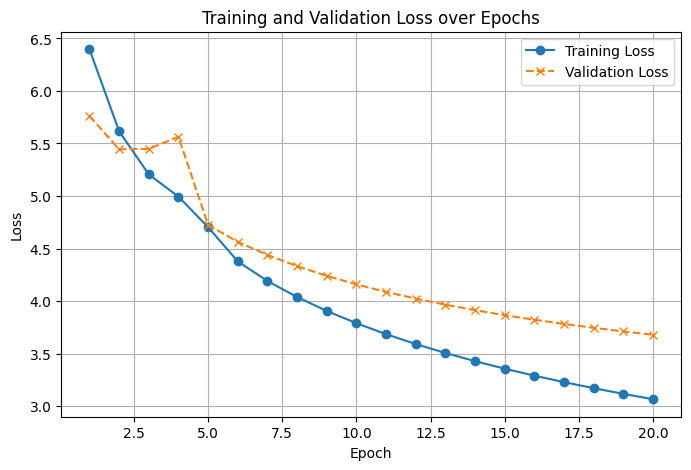

In [55]:
# Plot loss curve
plt.figure(figsize=(8, 5))

# Plot training loss
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', label='Training Loss')

# Plot validation loss
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', linestyle='--', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()